<a href="https://colab.research.google.com/github/paurbano/aplicaciones-financieras/blob/main/Taller_final_Modulo_2_Aplicaciones_financieras_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [1]:
!pip install -U plotly

In [1]:
import pandas as pd
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

#Datos
Variable objetivo: costo del seguro

##Cargar Dataset

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
data.describe()
#data.info()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#Preprocesamiento DataSet

## Transformar datos categoricos


In [4]:
# seleccionamos solo los datos categoricos
cat = data.select_dtypes(include=[object])
# cat.head(3)
cat.shape

(1338, 3)

### Codificación de variables categoricas

In [5]:
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()
data['sex_encoded'] = le_sex.fit_transform(data.sex)
data['smoker_encoded'] = le_smoker.fit_transform(data.smoker)
data['region_encoded'] = le_region.fit_transform(data.region)
data.head(5)

,age,sex,bmi,children,smoker,region,charges,sex_encoded,smoker_encoded,region_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1


In [6]:
# sex_ohe = OneHotEncoder()
# smoker_ohe = OneHotEncoder()
region_ohe = OneHotEncoder()
region_fit = region_ohe.fit_transform(data.region_encoded.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(region_fit, columns=["region_"+str(int(i)) for i in range(region_fit.shape[1])])
data = pd.concat([data,dfOneHot], axis=1)


In [8]:
data

,age,sex,bmi,children,smoker,region,charges,sex_encoded,smoker_encoded,region_encoded,region_0,region_1,region_2,region_3
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,2,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,3,0.0,0.0,0.0,1.0


In [7]:
preprocessData = data.drop(columns=['sex','smoker','region','region_encoded'])
preprocessData

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_0,region_1,region_2,region_3
0,19,27.900,0,16884.92400,0,1,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1,0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1,0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1,0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,0.0,1.0,0.0,0.0
1334,18,31.920,0,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,36.850,0,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,25.800,0,2007.94500,0,0,0.0,0.0,0.0,1.0


# División Datos : Entrenamiento, Validación y Prueba

In [8]:
# Variables predictores o de entrada
X = preprocessData.drop(columns=['charges'])
# Variable de Salida u Objetivo a predecir
Y = preprocessData['charges']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   bmi             1338 non-null   float64
 2   children        1338 non-null   int64  
 3   sex_encoded     1338 non-null   int64  
 4   smoker_encoded  1338 non-null   int64  
 5   region_0        1338 non-null   float64
 6   region_1        1338 non-null   float64
 7   region_2        1338 non-null   float64
 8   region_3        1338 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 94.2 KB


In [9]:
Y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [12]:
# División en conjunto de entrenamiento (80%), validación (10%) y prueba (10%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = .8, random_state = 10)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = .5, random_state = 10)
print('Dimensiones de:')
print('\tTrain:', X_train.shape, y_train.shape)
print('\tValidation:', X_val.shape, y_val.shape)
print('\tTest:', X_test.shape, y_test.shape)

Dimensiones de:
	Train: (1070, 9) (1070,)
	Validation: (134, 9) (134,)
	Test: (134, 9) (134,)


# Regresión Lineal

In [10]:
x_predictors=['age','bmi','children','sex_encoded','smoker_encoded','region_0','region_1','region_2','region_3']

transformer = ColumnTransformer(
    [
     ('transformador', StandardScaler(), x_predictors)
    ]
)

pipe = Pipeline(
    [
     ('procesamiento', transformer), 
     ('modelo', LinearRegression())
    ]
)

In [13]:
#y_train
pipe.fit(X_train, y_train)

Pipeline(steps=[('procesamiento',
                 ColumnTransformer(transformers=[('transformador',
                                                  StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'sex_encoded',
                                                   'smoker_encoded', 'region_0',
                                                   'region_1', 'region_2',
                                                   'region_3'])])),
                ('modelo', LinearRegression())])

In [14]:
# intercepto
print('Intercepto:',pipe.named_steps['modelo'].intercept_)
# coeficientes
print('Coeficientes :', pipe.named_steps['modelo'].coef_)

Intercepto: 13199.839422541123
Coeficientes : [3670.81343655 2169.10769455  656.60949585 -127.18792956 9700.00356068
  187.0947029   103.0424982  -205.23363482  -79.41239429]


## Predicción

In [15]:
# Entrenar modelo usando los datos de entrenamiento
y_train_linreg = pipe.predict(X_train)
# Hacer predicciones usando el conjunto de pruebas
y_test_linreg = pipe.predict(X_test)

In [17]:
y_test_linreg.shape

(134,)

# Desempeño

In [18]:
# El error cuadrático medio
mse_test_linreg = mean_squared_error(y_test, y_test_linreg)
# El coeficiente de determinación: 1 es una predicción perfecta
r2_score_ = r2_score(y_test, y_test_linreg)
print(
    f'MSE train: {mean_squared_error(y_train, y_train_linreg)}',
    f'MSE test: {mse_test_linreg}',
    f'Coeficiente de Determinación: {r2_score_}',sep='\n')

MSE train: 35000135.31385897
MSE test: 38811442.97853931
Coeficiente de Determinación: 0.7324707735498308


In [19]:
print(X_test.shape,y_test.shape)


(134, 9) (134,)


ValueError: ignored

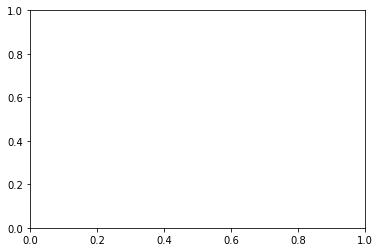

In [19]:
# error por diferentes tamaños en los arreglos
plt.scatter(X_test, y_test,  color='black')
## --------------------------------------------##
plt.plot(X_test, y_pred_linreg, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Red Neural
## Modelo

In [29]:
# probar varias arquitecturas de red
model = K.Sequential(
    [
     K.layers.Input((9, )), 
     K.layers.Normalization(), 
     K.layers.Dense(10, activation = 'sigmoid'), 
     K.layers.Dense(20, activation = 'sigmoid'), 
     K.layers.Dense(20, activation = 'sigmoid'), 
     K.layers.Dense(1),
    ]
)
# opt = K.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
opt = K.optimizers.RMSprop(1e-3)
# opt = K.optimizers.Adam()
loss_function = 'mse'
# loss_function = 'categorical_crossentropy'
model.compile(
    loss = loss_function, 
    optimizer = opt
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 10)                100       
                                                                 
 dense_17 (Dense)            (None, 20)                220       
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 780
Trainable params: 761
Non-trainable params: 19
_______________________________________________________

## Callbacks

In [27]:
early_stopping_cb = K.callbacks.EarlyStopping(
    patience = 500, 
    restore_best_weights = True
)

## Entrenamiento

In [31]:
history = model.fit(
    X_train, y_train, 
    epochs = 30000, 
    batch_size = 256, 
    validation_data = (X_val, y_val), 
    callbacks = [early_stopping_cb]
)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
5/5 [==============================] - 0s 13ms/step - loss: 254342848.0000 - val_loss: 251559504.0000
Epoch 27502/30000
5/5 [==============================] - 0s 14ms/step - loss: 254340768.0000 - val_loss: 251557360.0000
Epoch 27503/30000
5/5 [==============================] - 0s 13ms/step - loss: 254338656.0000 - val_loss: 251555040.0000
Epoch 27504/30000
5/5 [==============================] - 0s 18ms/step - loss: 254336480.0000 - val_loss: 251552752.0000
Epoch 27505/30000
5/5 [==============================] - 0s 14ms/step - loss: 254334304.0000 - val_loss: 251550448.0000
Epoch 27506/30000
5/5 [==============================] - 0s 14ms/step - loss: 254332112.0000 - val_loss: 251548240.0000
Epoch 27507/30000
5/5 [==============================] - 0s 14ms/step - loss: 254330000.0000 - val_loss: 251546080.0000
Epoch 27508/30000
5/5 [==============================] - 0s 13ms/step - loss: 254327936.0000 - val_loss: 251543

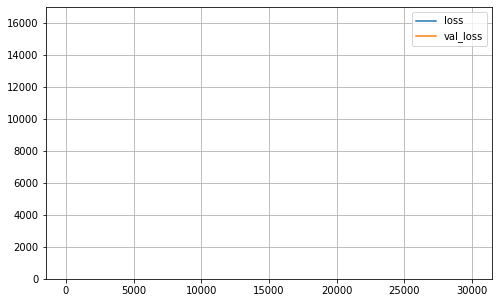

In [34]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,17000)
plt.show()

In [36]:
print(model.evaluate(X_test,y_test,verbose=False))

250776720.0


In [41]:
y_pred = model.predict(X_test)
y_pred.shape

(134, 1)